<a id="im"></a>
# <center>IMPORTING LIBRARIES</center>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

2023-10-22 01:34:55.476789: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-22 01:34:55.502718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 01:34:55.502756: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 01:34:55.502781: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 01:34:55.509422: I tensorflow/core/platform/cpu_feature_g

In [3]:
# np.random.seed(1)
# INPUT_DIR = './data/'
# train_data = pd.read_csv(INPUT_DIR + 'train_labels.csv')
# train_data['path'] = INPUT_DIR + 'train/' + train_data['label'] + '/' + train_data['image_id']
# 
# from PIL import Image
# from tqdm.notebook import tqdm
# 
# for i, p in tqdm(enumerate(train_data['path'].values)):
# 
# 
#     img = Image.open(p)
# 
#     for it in range(10):
#         new_img = img.rotate(np.random.rand() * 60 - 30, resample=3)
# 
#         if np.random.rand() > 0.5:
#             new_img = new_img.transpose(Image.FLIP_LEFT_RIGHT)
# 
#         new_img_name = INPUT_DIR + 'train/' + train_data['label'].values[i] + '/' + train_data['image_id'].values[i] + '_' + str(it) + '.png'
#         new_img.save(new_img_name)
#     if i % 100 == 0:
#         print(str(i) + new_img_name)

In [4]:
# import os
# import shutil
# 
# train_dir = "data/train"
# test_dir = "data/test"
# emotions = ["angry", "fearful", "happy", "neutral", "sad", "surprised"]
# 
# for emotion in emotions:
#     test_emotion_dir = os.path.join(test_dir, emotion)
#     train_emotion_dir = os.path.join(train_dir, emotion)
# 
#     for filename in os.listdir(train_emotion_dir):
#         if "test" in filename:
#             src_file = os.path.join(train_emotion_dir, filename)
#             dest_file = os.path.join(test_emotion_dir, filename)
#             shutil.move(src_file, dest_file)

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [5]:
train_dir = "data/train"
test_dir = "data/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 12
FINE_TUNING_EPOCHS = 10
LR = 0.01
NUM_CLASSES = 6
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [6]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

# preprocess_fun = tf.keras.applications.densenet.preprocess_input
preprocess_fun = to_grayscale_then_rgb

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 248803 images belonging to 6 classes.
Found 62200 images belonging to 6 classes.
Found 77737 images belonging to 6 classes.


## Data distribution (count) among differnt emotions

In [7]:
classLabelCounts = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)]
for classLabel, classLabelCount in zip(CLASS_LABELS, classLabelCounts):
  print(classLabel, classLabelCount)

Anger 35156
Fear 36054
Happy 63492
Neutral 43692
Sadness 42504
Surprise 27905


<a id="model"></a>
# <center> DenseNet169 Transfer Learning  </center>

In [8]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.05), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [9]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               852480    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                             

<a id="train"></a>
# <center> Training and Fine-Tuning </center> 

## Training model with freezed layers of DenseNer169

In [10]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS,
                    validation_data = validation_generator, 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/12


2023-10-22 01:35:22.419976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904
2023-10-22 01:35:22.562389: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-10-22 01:35:22.562430: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-10-22 01:35:22.562514: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-22 01:35:22.760304: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-10-22 01:35:25.050498: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_k

3888/3888 [==============================] - 583s 142ms/step - loss: 4.0265 - accuracy: 0.5173 - val_loss: 1.2463 - val_accuracy: 0.5678
Epoch 2/12
3888/3888 [==============================] - 444s 114ms/step - loss: 0.9677 - accuracy: 0.6626 - val_loss: 1.2032 - val_accuracy: 0.5973
Epoch 3/12
3888/3888 [==============================] - 436s 112ms/step - loss: 0.8159 - accuracy: 0.7261 - val_loss: 1.2337 - val_accuracy: 0.5932
Epoch 4/12
3888/3888 [==============================] - 435s 112ms/step - loss: 0.6801 - accuracy: 0.7816 - val_loss: 1.2995 - val_accuracy: 0.5992
Epoch 5/12
3888/3888 [==============================] - 437s 112ms/step - loss: 0.5587 - accuracy: 0.8270 - val_loss: 1.4044 - val_accuracy: 0.6020
Epoch 5: early stopping


## Fine Tuning

In [21]:
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)

Epoch 1/10


2023-10-22 14:08:43.002084: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


3888/3888 [==============================] - 564s 134ms/step - loss: 0.9127 - accuracy: 0.7004 - val_loss: 1.1637 - val_accuracy: 0.6130
Epoch 2/10
3888/3888 [==============================] - 524s 135ms/step - loss: 0.7490 - accuracy: 0.7642 - val_loss: 1.2215 - val_accuracy: 0.6095
Epoch 3/10
3888/3888 [==============================] - 512s 132ms/step - loss: 0.5871 - accuracy: 0.8256 - val_loss: 1.3958 - val_accuracy: 0.5938
Epoch 4/10
3888/3888 [==============================] - 476s 122ms/step - loss: 0.4640 - accuracy: 0.8699 - val_loss: 1.5203 - val_accuracy: 0.6140
Epoch 5/10
3888/3888 [==============================] - 456s 117ms/step - loss: 0.3802 - accuracy: 0.8986 - val_loss: 1.4273 - val_accuracy: 0.6225
Epoch 6/10
3888/3888 [==============================] - 456s 117ms/step - loss: 0.3255 - accuracy: 0.9165 - val_loss: 1.5251 - val_accuracy: 0.6375
Epoch 7/10
3888/3888 [==============================] - 459s 118ms/step - loss: 0.2908 - accuracy: 0.9279 - val_loss: 1.600

In [22]:
history = history._append(pd.DataFrame(history_.history) , ignore_index=True)

## Model Evaluation

In [23]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

1215/1215 [==============================] - 106s 86ms/step


## Confusion Matrix

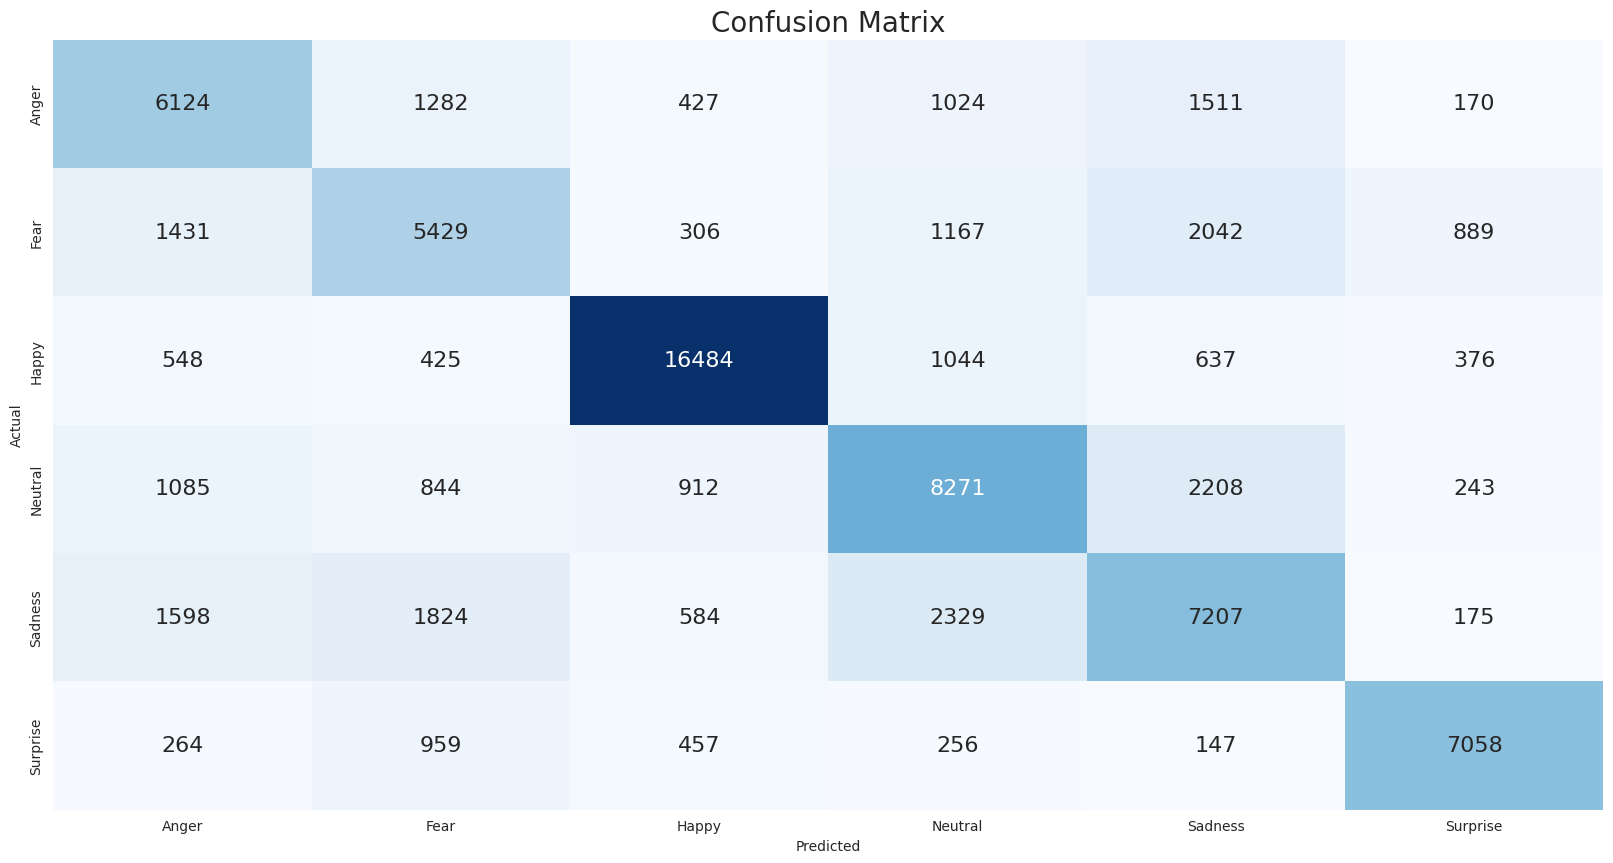

In [14]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [15]:
model.save('../cfg/model_modified.h5')

In [16]:
from sklearn. metrics import f1_score
f1_score(y_preds, y_test, average="weighted")

0.6499524230960987

In [17]:
# ! pip install -q kaggle
# from google.colab import files
#
# files.upload()
# ! mkdir ~/.kaggle
#
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [18]:
# ! kaggle datasets download -d ananthu017/emotion-detection-fer

In [19]:
# import zipfile
# import os
#
# data_r = zipfile.ZipFile('/content/emotion-detection-fer.zip', 'r')
# data_r.extractall()

In [20]:
# import shutil, sys
# shutil.rmtree('/content/test/disgusted')